In [1]:
import pandas as pd
import numpy as np
import imageio
import os
from tifffile import imread
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from skimage.util import img_as_ubyte

%load_ext autoreload
%autoreload 2
%load_ext lab_black

PATH = "/Users/giovanni.palla/Datasets/20200909_PublicVisium_giovanni.palla_LIGHWEIGHT/20191205_10XVisium_MouseBrainCoronal_giovanni.palla"

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


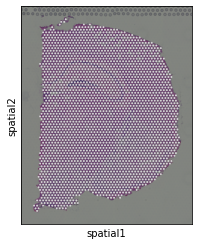

In [2]:
adata = sc.read_visium(
    PATH, count_file="V1_Adult_Mouse_Brain_filtered_feature_bc_matrix.h5"
)
sc.pl.spatial(adata)

In [3]:
img_path = os.path.join(PATH, "V1_Adult_Mouse_Brain_image.tif")
img = imread(img_path)

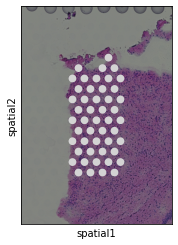

In [4]:
crop = (adata.obsm["spatial"][:, 0] < 3000) & (adata.obsm["spatial"][:, 1] < 3000)
crop_coord = adata.obsm["spatial"][crop, :]
sc.pl.spatial(adata[crop])

In [5]:
scalef_lowres = adata.uns["spatial"]["V1_Adult_Mouse_Brain"]["scalefactors"][
    "tissue_lowres_scalef"
]
adata.uns["spatial"]["V1_Adult_Mouse_Brain"]["scalefactors"]

{'spot_diameter_fullres': 89.44476048022638,
 'tissue_hires_scalef': 0.17011142,
 'fiducial_diameter_fullres': 144.48769000651953,
 'tissue_lowres_scalef': 0.051033426}

In [6]:
min_x = crop_coord[:, 1].min() - 200
max_x = crop_coord[:, 1].max() + 200
min_y = crop_coord[:, 0].min() - 200
max_y = crop_coord[:, 0].max() + 200
img_crop = img[min_x:max_x, min_y:max_y]

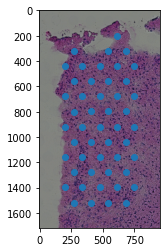

In [7]:
plt.imshow(img_crop)
plt.scatter(crop_coord[:, 0] - min_y, crop_coord[:, 1] - min_x)

In [8]:
adata_filt = adata[crop].copy()
adata_filt.obsm["spatial"][:, 0] = adata_filt.obsm["spatial"][:, 0] - min_y
adata_filt.obsm["spatial"][:, 1] = adata_filt.obsm["spatial"][:, 1] - min_x

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


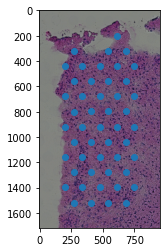

In [9]:
plt.imshow(img_crop)
plt.scatter(adata_filt.obsm["spatial"][:, 0], adata_filt.obsm["spatial"][:, 1])

In [10]:
img_lowres = adata_filt.uns["spatial"]["V1_Adult_Mouse_Brain"]["images"]["lowres"]

In [11]:
min_x = int(np.round((crop_coord[:, 1].min() - 200) * scalef_lowres))
max_x = int(np.round((crop_coord[:, 1].max() + 200) * scalef_lowres))
min_y = int(np.round((crop_coord[:, 0].min() - 200) * scalef_lowres))
max_y = int(np.round((crop_coord[:, 0].max() + 200) * scalef_lowres))
img_lowres_crop = img_lowres[min_x:max_x, min_y:max_y]

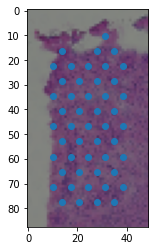

In [12]:
plt.imshow(img_lowres_crop)
plt.scatter(
    adata_filt.obsm["spatial"][:, 0] * scalef_lowres,
    adata_filt.obsm["spatial"][:, 1] * scalef_lowres,
)

In [13]:
adata_filt.uns["spatial"]["V1_Adult_Mouse_Brain"]["images"]["hires"] = 0
adata_filt.uns["spatial"]["V1_Adult_Mouse_Brain"]["images"]["lowres"] = img_lowres_crop

adata_filt.obs.drop(columns=["array_row", "array_col"], inplace=True)
adata_filt.var.drop(columns=["feature_types", "genome"], inplace=True)
adata_filt = adata_filt[:, 0:100].copy()

In [14]:
adata_filt.write("./../spatial_tools/tests/_data/test_data.h5ad")

In [15]:
img_crop = img_as_ubyte(img_crop)
imageio.imwrite("./../spatial_tools/tests/_data/test_img.jpg", img_crop)